In [1]:
import json
from functools import partial
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split


In [2]:
%load_ext autoreload
%autoreload 2

### Load data

In [3]:
dataset = pd.read_parquet("./data/full_dataset.parquet")
etl = pd.read_parquet("./data/train_data.parquet")

test_dataset = pd.read_parquet("./data/test_data.parquet")
test_pairs = pd.read_parquet("./data/test_pairs_wo_target.parquet")


In [4]:
etl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456843 entries, 0 to 457062
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   variantid                          456843 non-null  int64 
 1   name                               456843 non-null  object
 2   color_parsed                       378543 non-null  object
 3   pic_embeddings_resnet_v1           303317 non-null  object
 4   main_pic_embeddings_resnet_v1      456843 non-null  object
 5   name_bert_64                       456843 non-null  object
 6   characteristic_attributes_mapping  456816 non-null  object
 7   cat_3                              456843 non-null  object
 8   cat_4                              456843 non-null  object
 9   name_preprocessed                  456843 non-null  object
 10  name_dimensions                    456843 non-null  object
 11  name_code                          456843 non-null  objec

In [5]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35730 entries, 0 to 35729
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   variantid                          35730 non-null  int64 
 1   name                               35730 non-null  object
 2   color_parsed                       26089 non-null  object
 3   pic_embeddings_resnet_v1           19977 non-null  object
 4   main_pic_embeddings_resnet_v1      35730 non-null  object
 5   name_bert_64                       35730 non-null  object
 6   characteristic_attributes_mapping  35726 non-null  object
 7   cat_3                              35730 non-null  object
 8   cat_4                              35730 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.5+ MB


In [6]:
etl.head(2)

,variantid,name,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping,cat_3,cat_4,name_preprocessed,name_dimensions,name_code,name_rus_abbreviations,name_eng_abbreviations,name_model,tokens,name_full_preprocessed,name_tokens
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","[Номинальный ток, А_10, Цвет товара_оранжевый,...","Сетевые фильтры, разветвители и удлинители","Сетевой фильтр, удлинитель, разветвитель",Удлинитель Партнер-Электро ПВС 2х0 75 ГОСТ 6А3...,[],[],"[ПВС, ГОСТ]",[IP],"[2х0, 6А30]","[удлинитель, партнерэлектро, пвс, 2х075, гост6...",удлинитель партнерэлектро пвс гост метровip,"[удлинитель, партнерэлектро, пвс, гост, метровip]"
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...",[Конструктивные особенности_Магнитная конструк...,Кабели и переходники,Кабель,Магнитный кабель USB (m) - USB (m) Baseus Zi...,"[2.0 А, 2 м]","[Type-C, CATXC-B09]",[],"[USB, USB]",[],"[магнитный, кабель, usb, 20, usb, typec, 2м, b...",магнитный кабель usb usb typec baseus zinc mag...,"[магнитный, кабель, usb, usb, typec, baseus, z..."


### Create text features

In [7]:
from utils.text_features import create_text_features
etl = create_text_features(etl)

[nltk_data] Downloading package wordnet to /home/ana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
test_dataset = create_text_features(test_dataset)

In [9]:
etl.head(2)

,variantid,name,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping,cat_3,cat_4,name_preprocessed,name_dimensions,name_code,name_rus_abbreviations,name_eng_abbreviations,name_model,tokens,name_full_preprocessed,name_tokens
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","[Номинальный ток, А_10, Цвет товара_оранжевый,...","Сетевые фильтры, разветвители и удлинители","Сетевой фильтр, удлинитель, разветвитель",Удлинитель Партнер-Электро ПВС 2х0 75 ГОСТ 6А3...,[],[],"[ПВС, ГОСТ]",[IP],"[2х0, 6А30]","[удлинитель, партнерэлектро, пвс, 2х075, гост6...",удлинитель партнерэлектро пвс гост метровip,"[удлинитель, партнерэлектро, пвс, гост, метровip]"
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...",[Конструктивные особенности_Магнитная конструк...,Кабели и переходники,Кабель,Магнитный кабель USB (m) - USB (m) Baseus Zi...,"[2.0 А, 2 м]","[Type-C, CATXC-B09]",[],"[USB, USB]",[],"[магнитный, кабель, usb, 20, usb, typec, 2м, b...",магнитный кабель usb usb typec baseus zinc mag...,"[магнитный, кабель, usb, usb, typec, baseus, z..."


In [ ]:
from utils.cat_features import cat_features
etl = cat_features(etl)

In [ ]:
test_dataset = cat_features(test_dataset)

35730it [00:04, 7646.29it/s]


In [11]:
etl.head(2)

,variantid,name,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping,cat_3,cat_4,name_preprocessed,name_dimensions,name_code,name_rus_abbreviations,name_eng_abbreviations,name_model,tokens,name_full_preprocessed,name_tokens
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","[Номинальный ток, А_10, Цвет товара_оранжевый,...","Сетевые фильтры, разветвители и удлинители","Сетевой фильтр, удлинитель, разветвитель",Удлинитель Партнер-Электро ПВС 2х0 75 ГОСТ 6А3...,[],[],"[ПВС, ГОСТ]",[IP],"[2х0, 6А30]","[удлинитель, партнерэлектро, пвс, 2х075, гост6...",удлинитель партнерэлектро пвс гост метровip,"[удлинитель, партнерэлектро, пвс, гост, метровip]"
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...",[Конструктивные особенности_Магнитная конструк...,Кабели и переходники,Кабель,Магнитный кабель USB (m) - USB (m) Baseus Zi...,"[2.0 А, 2 м]","[Type-C, CATXC-B09]",[],"[USB, USB]",[],"[магнитный, кабель, usb, 20, usb, typec, 2м, b...",магнитный кабель usb usb typec baseus zinc mag...,"[магнитный, кабель, usb, usb, typec, baseus, z..."


Get raw data for each variantid.

In [12]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

### Create Features

In [13]:
from utils.text_features import jaccard_similarity

In [14]:
features.head(2)

,variantid1,variantid2,target,name1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,cat_31,...,cat_42,name_preprocessed2,name_dimensions2,name_code2,name_rus_abbreviations2,name_eng_abbreviations2,name_model2,tokens2,name_full_preprocessed2,name_tokens2
0,587809782,615149925,1.0,Картридж лазерный Комус 729 (4370B002) чер. дл...,[черный],None,"[[-0.041107245, 0.48485547, -0.2837791, 0.4637...","[-0.5087511, 0.46164495, 0.42914906, -0.462508...","[Тип_Картридж, Бренд_Нет бренда]",Расходник для печати,...,Картридж,Картридж лазерный Комус 729 (4368B002) пур. дл...,[],[],[],[],"[4368B002, CanonLBP7010C]","[картридж, лазерный, комус, 729, 4368b002, пур...",картридж лазерный комус пур,"[картридж, лазерный, комус, пур]"
1,53602615,615149925,1.0,Картридж лазерный Комус 729 (4368B002) пурпурн...,[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","[Назначение_для лазерного принтера, Совместимы...",Расходник для печати,...,Картридж,Картридж лазерный Комус 729 (4368B002) пур. дл...,[],[],[],[],"[4368B002, CanonLBP7010C]","[картридж, лазерный, комус, 729, 4368b002, пур...",картридж лазерный комус пур,"[картридж, лазерный, комус, пур]"


In [15]:
# color features
features['color_similarity'] = features.apply(lambda row: jaccard_similarity(row['color_parsed1'], row['color_parsed2']), axis=1)

In [16]:
features['name_tokens_jaccard'] = features.apply(lambda row: jaccard_similarity(row['name_tokens1'], row['name_tokens2']), axis=1)
features['name_dimensions_similarity'] = features.apply(lambda row: jaccard_similarity(row['name_dimensions1'], row['name_dimensions2']), axis=1)
features['name_code_similarity'] = features.apply(lambda row: jaccard_similarity(row['name_code1'], row['name_code2']), axis=1)

features['name_rus_abbreviations_similarity'] = features.apply(lambda row: jaccard_similarity(row['name_rus_abbreviations1'], 
                                                                                              row['name_rus_abbreviations2']), axis=1)

features['name_eng_abbreviations_similarity'] = features.apply(lambda row: jaccard_similarity(row['name_eng_abbreviations1'], 
                                                                                              row['name_eng_abbreviations2']), axis=1)

features['name_model_similarity'] = features.apply(lambda row: jaccard_similarity(row['name_model1'], row['name_model2']), axis=1)
features['lemmas_similarity'] = features.apply(lambda row: jaccard_similarity(row['tokens1'], row['tokens2']), axis=1)

In [17]:
from utils.image_features import get_pic_features
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[25, 50, 75]
)

In [34]:
features[["pic_dist_25_perc", "pic_dist_50_perc", "pic_dist_75_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "euclidean")), axis=1
    )
)

features[["main_pic_dist_25_perc", "main_pic_dist_50_perc", "main_pic_dist_75_perc"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "euclidean")), axis=1
    )
)

In [35]:
features[["cos_pic_dist_25_perc", "cos_pic_dist_50_perc", "cos_pic_dist_75_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "cosine")), axis=1
    )
)

features[["main_cos_pic_dist_25_perc", "main_cos_pic_dist_50_perc", "main_cos_pic_dist_75_perc"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "cosine")), axis=1
    )
)

In [26]:
from utils.image_features import get_pic_features_mean
features["mean_pic"] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x)), axis=1
    )
)
features["cos_mean_pic"] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x, "cosine")), axis=1
    )
)

features["main_mean_pic"] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x)), axis=1
    )
)
features["main_cos_mean_pic"] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x, "cosine")), axis=1
    )
)

In [20]:
from utils.text_features import text_dense_distances
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)


In [21]:
from utils.training import create_3cat_grouped
features = create_3cat_grouped(features)

Choose features

In [86]:
features.columns

Index(['variantid1', 'variantid2', 'target', 'name1', 'color_parsed1',
       'pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v11',
       'name_bert_641', 'characteristic_attributes_mapping1', 'cat_31',
       'cat_41', 'name_preprocessed1', 'name_dimensions1', 'name_code1',
       'name_rus_abbreviations1', 'name_eng_abbreviations1', 'name_model1',
       'tokens1', 'name_full_preprocessed1', 'name_tokens1', 'name2',
       'color_parsed2', 'pic_embeddings_resnet_v12',
       'main_pic_embeddings_resnet_v12', 'name_bert_642',
       'characteristic_attributes_mapping2', 'cat_32', 'cat_42',
       'name_preprocessed2', 'name_dimensions2', 'name_code2',
       'name_rus_abbreviations2', 'name_eng_abbreviations2', 'name_model2',
       'tokens2', 'name_full_preprocessed2', 'name_tokens2',
       'color_similarity', 'name_tokens_jaccard', 'name_dimensions_similarity',
       'name_code_similarity', 'name_rus_abbreviations_similarity',
       'name_eng_abbreviations_similarity', 

In [37]:
features.head(2)

,variantid1,variantid2,target,name1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,cat_31,...,mean_pic,cos_mean_pic,main_mean_pic,main_cos_mean_pic,main_pic_dist_25_perc,main_pic_dist_50_perc,main_pic_dist_75_perc,main_cos_pic_dist_25_perc,main_cos_pic_dist_50_perc,main_cos_pic_dist_75_perc
0,587809782,615149925,1.0,Картридж лазерный Комус 729 (4370B002) чер. дл...,[черный],None,"[[-0.041107245, 0.48485547, -0.2837791, 0.4637...","[-0.5087511, 0.46164495, 0.42914906, -0.462508...","[Тип_Картридж, Бренд_Нет бренда]",Расходник для печати,...,-1.0,-1.0,0.230155,0.000664,0.230155,0.230155,0.230155,0.000664,0.000664,0.000664
1,53602615,615149925,1.0,Картридж лазерный Комус 729 (4368B002) пурпурн...,[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","[Назначение_для лазерного принтера, Совместимы...",Расходник для печати,...,-1.0,-1.0,0.985881,0.010815,0.985881,0.985881,0.985881,0.010815,0.010815,0.010815


In [96]:
feats = [
       'color_similarity', 'name_tokens_jaccard', 'name_dimensions_similarity',
       'name_code_similarity', 'name_rus_abbreviations_similarity',
       'name_eng_abbreviations_similarity', 'name_model_similarity',
       'lemmas_similarity', 'pic_dist_50_perc',
        'cos_pic_dist_50_perc',
       'euclidean_name_bert_dist',
       'cosine_name_bert_dist', 'mean_pic', 'cos_mean_pic',
       'main_mean_pic', 'main_cos_mean_pic', 
       'main_pic_dist_50_perc',
        'main_cos_pic_dist_50_perc'
       ]

Split dataset

In [97]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]
metric_y_val = X_val[["target", "variantid1", "variantid2", "cat3_grouped"]]
metric_y_val_pred = X_val[["variantid1", "variantid2"]]
X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

### Optuna

In [98]:
from utils.metric import pr_auc_macro
import optuna
from optuna.samplers import TPESampler
def catboost_clf_objective(trial):

  model = CatBoostClassifier(
      task_type=trial.suggest_categorical('task_type', ['GPU']),
      iterations=trial.suggest_int('iterations', 400, 1000),
      learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
      depth=trial.suggest_int('depth', 2, 11),
      border_count=trial.suggest_int("border_count", 32, 255), 
      l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.5, 5, log=True),
      bootstrap_type=trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
      verbose=False
  )

  model.fit(X_train[feats], y_train)
  
  y_pred = model.predict(X_val[feats])
  metric_y_val_pred["scores"] = y_pred

  return pr_auc_macro(
    metric_y_val, 
    metric_y_val_pred

)

In [99]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name='catboost', direction='maximize', sampler=sampler)
study.optimize(catboost_clf_objective, n_trials=30)

In [100]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
Value:  0.4343203235351414
Params: 
    task_type: GPU
    iterations: 905
    learning_rate: 0.07396201213608415
    depth: 11
    border_count: 70
    l2_leaf_reg: 2.0429517369891417
    bootstrap_type: Bayesian


Train model

In [101]:
from utils.training import train
model_params = {"task_type":'GPU',
      "iterations": 10000,
      "learning_rate":0.07,
      "depth": 11,
      "border_count": 70,
      "l2_leaf_reg":2.04,
      "bootstrap_type":'Bayesian',
      "verbose": False}
fit_params = { "eval_set":eval_pool,
    "plot":True,
    "verbose":True,
    "use_best_model":True,
    "early_stopping_rounds":700,
    "metric_period":100}
save_path = "emb_model2.cbm"

In [102]:
model = train(model_params, train_pool,  fit_params, save_path)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6613651	test: 0.6615951	best: 0.6615951 (0)	total: 32.3ms	remaining: 5m 22s
100:	learn: 0.4296915	test: 0.4426024	best: 0.4426024 (100)	total: 3.25s	remaining: 5m 19s
200:	learn: 0.4080551	test: 0.4313996	best: 0.4313996 (200)	total: 6.47s	remaining: 5m 15s
300:	learn: 0.3922525	test: 0.4257096	best: 0.4257096 (300)	total: 9.67s	remaining: 5m 11s
400:	learn: 0.3790904	test: 0.4222883	best: 0.4222883 (400)	total: 12.9s	remaining: 5m 8s
500:	learn: 0.3678708	test: 0.4202074	best: 0.4202051 (499)	total: 16.1s	remaining: 5m 5s
600:	learn: 0.3576505	test: 0.4190088	best: 0.4190088 (600)	total: 19.4s	remaining: 5m 2s
700:	learn: 0.3488170	test: 0.4180191	best: 0.4180191 (700)	total: 22.6s	remaining: 4m 59s
800:	learn: 0.3407113	test: 0.4173157	best: 0.4173031 (799)	total: 25.8s	remaining: 4m 56s
900:	learn: 0.3327775	test: 0.4168958	best: 0.4168913 (898)	total: 29s	remaining: 4m 52s
1000:	learn: 0.3257827	test: 0.4167384	best: 0.4166960 (977)	total: 32.2s	remaining: 4m 49s
1100:	

### Metric

In [103]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [104]:
from utils.metric import *
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.5585511150608734

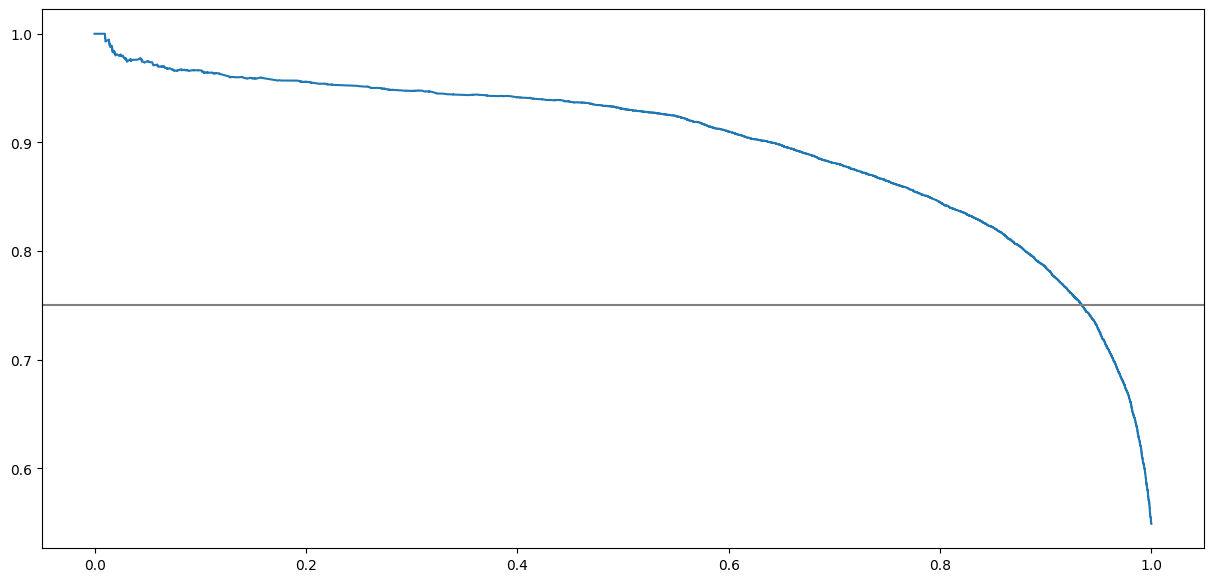

In [105]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [106]:
pr_auc 

0.8981756187636613

### Submission

Generate the same features as for train

In [107]:
test_features = (
    test_pairs
    .merge(
        test_dataset
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_dataset
        .add_suffix('2'),
        on="variantid2"
    )
)

In [108]:
test_features['color_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['color_parsed1'], row['color_parsed2']), axis=1)

In [109]:
test_features['name_tokens_jaccard'] = test_features.apply(lambda row: jaccard_similarity(row['name_tokens1'], row['name_tokens2']), axis=1)
test_features['name_dimensions_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name_dimensions1'], row['name_dimensions2']), axis=1)
test_features['name_code_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name_code1'], row['name_code2']), axis=1)

test_features['name_rus_abbreviations_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name_rus_abbreviations1'], 
                                                                                              row['name_rus_abbreviations2']), axis=1)

test_features['name_eng_abbreviations_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name_eng_abbreviations1'], 
                                                                                              row['name_eng_abbreviations2']), axis=1)

test_features['name_model_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name_model1'], row['name_model2']), axis=1)
test_features['lemmas_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['tokens1'], row['tokens2']), axis=1)

In [110]:
test_features[["pic_dist_25_perc", "pic_dist_50_perc", "pic_dist_75_perc"]] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "euclidean")), axis=1
    )
)

test_features[["main_pic_dist_25_perc", "main_pic_dist_50_perc", "main_pic_dist_75_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "euclidean")), axis=1
    )
)

In [111]:
test_features[["cos_pic_dist_25_perc", "cos_pic_dist_50_perc", "cos_pic_dist_75_perc"]] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "cosine")), axis=1
    )
)
test_features[["main_cos_pic_dist_25_perc", "main_cos_pic_dist_50_perc", "main_cos_pic_dist_75_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, "cosine")), axis=1
    )
)

In [112]:
test_features["mean_pic"] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x)), axis=1
    )
)
test_features["cos_mean_pic"] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x, "cosine")), axis=1
    )
)

test_features["main_mean_pic"] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x)), axis=1
    )
)
test_features["main_cos_mean_pic"] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_mean(*x, "cosine")), axis=1
    )
)

In [113]:
test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)


In [114]:
test_cat3_counts = test_features["cat_31"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [115]:
test_features["cat3_grouped"] = test_features["cat_31"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")


In [116]:
submission_example = test_features.copy()

In [117]:
submission_example["target"] = model.predict_proba(test_features[feats])[:, 1]

In [118]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [119]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example2.csv", index=False)